In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
mpl.rcParams["figure.dpi"] = 100
import seaborn as sns
plt.style.use('presentation.mplstyle')
import logging

# Get the logger for 'fontTools'
font_tools_logger = logging.getLogger('fontTools')

# Set the logging level to WARNING, which ignores DEBUG and INFO messages
font_tools_logger.setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\SI"

In [3]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[1]
path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")
spatial_temporal_graph,folders = load(path_tot)

In [4]:
def merge_hyperedge(hyperdege0,hyperedge1,graph):
    edges = graph.get_hyperedge_edges(hyperedge1)
    edges_new = merge(edges, graph)
    for u,v in edges_new:
        graph[u][v]["hyperedge"] = hyperdege0
# #441
        
merge_hyperedge(3169,3728,spatial_temporal_graph)
merge_hyperedge(3169,3874,spatial_temporal_graph)
#310

# merge_hyperedge(335,443,spatial_temporal_graph)
# merge_hyperedge(31,133,spatial_temporal_graph)
# merge_hyperedge(242,171,spatial_temporal_graph)
# merge_hyperedge(1586,673,spatial_temporal_graph)
# merge_hyperedge(1586,780,spatial_temporal_graph)
# merge_hyperedge(167,1583,spatial_temporal_graph)
# merge_hyperedge(167,640,spatial_temporal_graph)

In [5]:
exp = make_exp(spatial_temporal_graph,folders)
weights = {(begin, end): LineString(data['pixel_list']).length * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "length")
weights = {(begin, end): data['pixel_list'][0][0] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "x")
weights = {(begin, end): data['pixel_list'][0][1] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "y")
# weights = {(begin, end): np.abs(data["42"]['speed_backflow2']) for begin, end, data in
#            spatial_temporal_graph.edges(data=True)}
# nx.set_edge_attributes(spatial_temporal_graph, weights, "abs_speed_backflow2_42")
# spatial_temporal_graph._hyperedges_initial_edges_gathered = True
# get_abcisse(spatial_temporal_graph)

In [6]:
refs = {
    "310_20230830": {
        "20230901_Plate310": "20230901_0719_Plate06",
        "20230902_Plate310": "20230902_1343_Plate07",
        "20230903_Plate310": "20230903_1143_Plate07",
        "20230904_Plate310": "20230904_0942_Plate07",
        "20230905_Plate310": "20230905_1345_Plate07",
        # "20230906_Plate310" : "20230906_1220_Plate07",
    },
    "441_20230807": {
        "20230810_Plate441": "20230810_1005_Plate14",
        "20230811_Plate441": "20230811_1605_Plate14",
        "20230812_Plate441": "20230812_1006_Plate14",
        "20230813_Plate441": "20230813_1618_Plate14",
    },
    "449_20230807": {
        "20230813_Plate449": "20230813_1606_Plate10",
        "20230814_Plate449": "20230814_1019_Plate10",
        "20230815_Plate449": "20230815_1021_Plate10",
        "20230816_Plate449": "20230816_1027_Plate10",
        # "20230818_Plate449": "20230818_1107_Plate10",
    },
}
indexes = refs[plate_id]

In [7]:
import matplotlib.patches as patches
def show_region(region,ax,downsizing = 5):
    adjusted_region = [[coord / downsizing for coord in point] for point in region]

    # Display the image (assuming 'image' is your loaded image)
    # ax.imshow(image)

    # Calculate rectangle parameters
    x0, y0 = adjusted_region[0]  # Lower-left corner
    x1, y1 = adjusted_region[1]  # Upper-right corner
    print(x0,y0,x1,y1)
    # Create a rectangle patch
    rect = patches.Rectangle((y0, x0), y1 - y0, x1 - x0, linewidth=2, edgecolor='g', facecolor='none',alpha = 0.8)
    ax.add_patch(rect)

In [8]:
def check_has_video(edge,graph):
    for i in range(graph.max_age+1):
        if 'video_edge' in graph[edge[0]][edge[1]][str(i)]:
            return(True)
    return(False)

In [9]:
edges_info = [edge for edge in spatial_temporal_graph.edges() if check_has_video(edge,spatial_temporal_graph)]

In [10]:
all_infos = pd.DataFrame()
attribute_list = ["QBC_tot","QBC_net","water_flux","speed_backflow","speed_heaton","water_flux_heaton","speed_backflow2"]
static_atrribute = ["hyperedge",
                    "abcisse",
                    "x",
                    "y",
                   ]
edge_specific_attribute = ["ordered_mapping","R","mapping"]
iss = []
for edge in edges_info:
    for i in range(spatial_temporal_graph.max_age+1):
         if 'video_edge' in spatial_temporal_graph[edge[0]][edge[1]][str(i)]:
            if i not in iss:
                iss.append(i)
                # print(i,spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'])
            network_edge_infos = spatial_temporal_graph[edge[0]][edge[1]]
            for j in range(len(network_edge_infos[str(i)]['video_edge'])):
                edge_obj = spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'][j]
                x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
                x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
                for attribute in attribute_list:
                    if attribute in network_edge_infos[str(i)]:
                        edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute]
                for attribute in edge_specific_attribute:
                    edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute][j]
                for attribute in static_atrribute:
                    if attribute in network_edge_infos:
                        edge_obj.mean_data[attribute]=network_edge_infos[attribute]
                edge_data_csv = edge_obj.mean_data
                edge_data_csv['folder'] = folders["folder"].iloc[i]
                edge_data_csv['edge_network'] = edge

                if "water_flux" in edge_data_csv.keys():
                    edge_data_csv['ordered_final'] = -edge_data_csv['ordered_mapping']

                    edge_data_csv['ordered_final'] *= (1-2*(edge[0]>edge[1]))
                    edge_data_csv['ordered_final'] *= (1-2*(x1>x2))
                    # edge_data_csv['ordered_final'] *= (1-2*(edge_data_csv['water_flux']>0))

                edge_data_csv = pd.DataFrame(edge_data_csv).transpose()
                all_infos = pd.concat([all_infos,edge_data_csv])
    # break

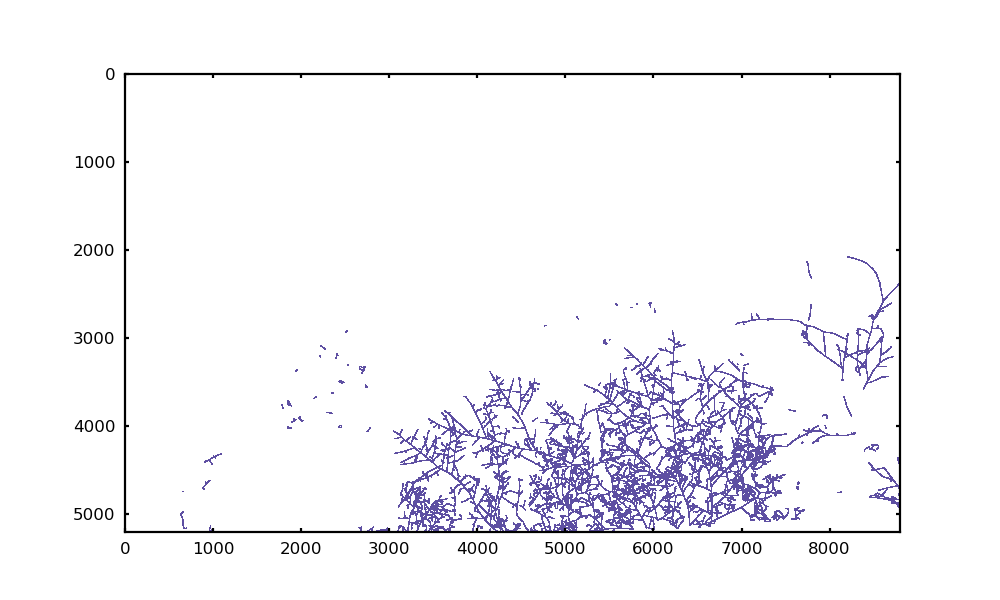

4213.413207732896 3202.019682970432 4296.213207732895 3315.069282970432
4213.413207732896 3202.019682970432 4296.213207732895 3315.069282970432
4147.687299961494 3165.641775551884 4230.4872999614945 3278.6913755518844
4147.687299961494 3165.641775551884 4230.4872999614945 3278.6913755518844
4342.605309092085 3361.7250316669392 4425.405309092085 3474.774631666939
4342.605309092085 3361.7250316669392 4425.405309092085 3474.774631666939
4442.953691791381 3527.0836009772347 4525.75369179138 3640.133200977235
4442.953691791381 3527.0836009772347 4525.75369179138 3640.133200977235
4477.979122214113 3602.9515073916227 4560.779122214113 3716.0011073916226
4477.979122214113 3602.9515073916227 4560.779122214113 3716.0011073916226
3997.1873749107035 3679.126969606704 4079.9873749107037 3792.1765696067037
3997.1873749107035 3679.126969606704 4079.9873749107037 3792.1765696067037
4050.470508215847 3793.2611454588273 4133.270508215847 3906.310745458827
4050.470508215847 3793.2611454588273 4133.27050

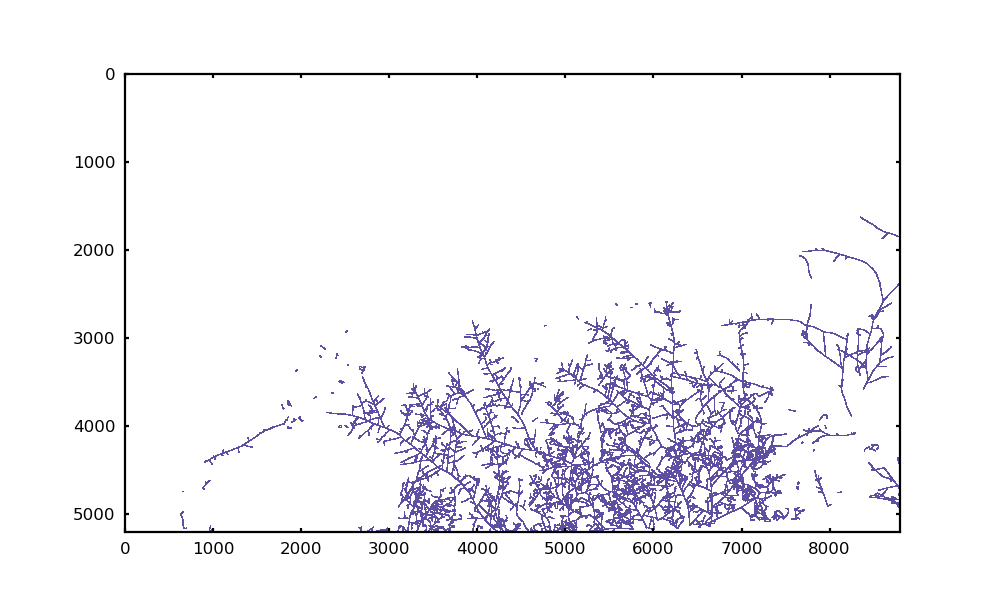

3954.332842804073 2842.556942668793 4037.1328428040733 2955.606542668793
3954.332842804073 2842.556942668793 4037.1328428040733 2955.606542668793
4013.072555413242 2991.606865328275 4095.872555413242 3104.656465328275
4013.072555413242 2991.606865328275 4095.872555413242 3104.656465328275
4079.505375328254 3083.913519338008 4162.305375328254 3196.963119338008
4079.505375328254 3083.913519338008 4162.305375328254 3196.963119338008
4213.413207732896 3202.019682970432 4296.213207732895 3315.069282970432
4213.413207732896 3202.019682970432 4296.213207732895 3315.069282970432
4202.5987130491285 3230.25158755245 4285.398713049129 3343.30118755245
4202.5987130491285 3230.25158755245 4285.398713049129 3343.30118755245
4147.687299961494 3165.641775551884 4230.4872999614945 3278.6913755518844
4147.687299961494 3165.641775551884 4230.4872999614945 3278.6913755518844
4342.605309092085 3361.7250316669392 4425.405309092085 3474.774631666939
4342.605309092085 3361.7250316669392 4425.405309092085 3474

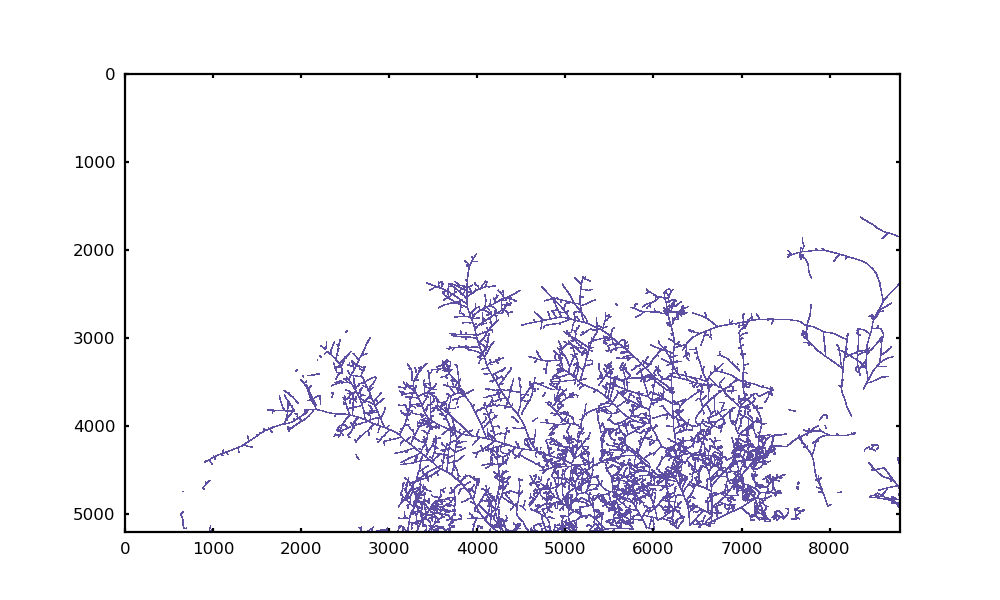

3823.301634602905 2047.3399794611516 3906.101634602905 2160.3895794611517
3823.301634602905 2047.3399794611516 3906.101634602905 2160.3895794611517
3798.129622174016 2236.054705298656 3880.929622174016 2349.1043052986556
3798.129622174016 2236.054705298656 3880.929622174016 2349.1043052986556
3815.3423783476924 2339.888015053212 3898.142378347692 2452.9376150532116
3815.3423783476924 2339.888015053212 3898.142378347692 2452.9376150532116
3857.411087436363 2594.614503105814 3940.211087436363 2707.664103105814
3857.411087436363 2594.614503105814 3940.211087436363 2707.664103105814
3857.411087436363 2594.614503105814 3940.211087436363 2707.664103105814
3857.411087436363 2594.614503105814 3940.211087436363 2707.664103105814
3857.411087436363 2594.614503105814 3940.211087436363 2707.664103105814
3954.332842804073 2842.556942668793 4037.1328428040733 2955.606542668793
3954.332842804073 2842.556942668793 4037.1328428040733 2955.606542668793
3954.332842804073 2842.556942668793 4037.13284280407

IndexError: index 0 is out of bounds for axis 0 with size 0

In [11]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

for index in indexes.keys():
    folder = indexes[index]
    folders = folders.sort_values(by="datetime") 
    matching_indexes = folders.loc[folders['folder'] == folder].index
    i_value = folders.index.get_loc(matching_indexes[0])
    minx = 0*5
    maxx = 26000
    miny = 0*5

    maxy = 44000
    select = all_infos[all_infos['folder']==folder]

    list_video = select["video_int"].unique()
    window_sizex = 3000*1.725/25
    window_sizey = 4096*1.725/25
    regions = []
    select = select[select["video_int"].isin(list_video)]
    for video_int in list_video:
        select_video = select[select["video_int"]==video_int].iloc[0]
        x,y = select_video["x"]/1.725,select_video["y"]/1.725
        beginx = x-window_sizex-minx
        endx = x+window_sizex-minx
        beginy = y-window_sizey-miny
        endy = y+window_sizey-miny
        regions.append([[beginx,beginy],[endx,endy]])
        spatial_temporal_graph_sub = create_subgraph_by_attribute(spatial_temporal_graph,"post_hyperedge_activation",i_value)
    vmax = 0.02
    vmin = -0.02
    t=0
    def color_edge(edge):
        return(vmax)
    exp = make_exp(spatial_temporal_graph_sub,folders)

    region = [[minx,miny],[maxx,maxy]]
    # region = [[0*5,0*5],[25000,44000]]

    fig, ax,f = plot_edge_color_value_3(
        exp,
        t,
        # lambda edge : edge.get_attribute("abcisse",t) ==3169,
        lambda edge : color_edge(edge),

        cmap=cm.get_cmap("Spectral", 100),
        v_min=vmin,
        v_max=vmax,
        plot_cmap=True,
        show_background=False,
        dilation=15,
        figsize=(5, 3),
        alpha = 1,
        region = region
    )

    for region in regions:
        show_region(region,ax)
    plt.xticks([])  # Removes 
    plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels
    plt.savefig(
        os.path.join(path_figure, f"imaging_{folder}.pdf"),
        transparent=True,
        bbox_inches="tight",
    )

In [ ]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm
